In [1]:
import numpy as np

from importlib import reload
import cluster
import prepare
import train
import evaluate

# contains code to evaluate according to semeval2018 metrics
import semeval_eval

from gensim.models.keyedvectors import KeyedVectors

import codecs
import argparse
import csv
import random

from collections import defaultdict
import numpy as np
try:
    from sklearn.model_selection import train_test_split
except ImportError:
    from sklearn.cross_validation import train_test_split

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# initialise embeddings and normalise to unit-norm
#model = KeyedVectors.load_word2vec_format('embeddings/GoogleNews-vectors-negative300.bin', binary=True)
#model = KeyedVectors.load_word2vec_format('embeddings/glove.42B.300d.txt', binary=False)
model = KeyedVectors.load_word2vec_format('embeddings/wiki-news-300d-1M.vec', binary=False)

#model.save_word2vec_format('embeddings/GoogleNews-vectors-negative300.txt', binary=False)
model.init_sims(replace=True)

In [3]:
# read original data
sub_train = prepare.read_subsumptions('subsumptions-train.txt')
sub_test = prepare.read_subsumptions('subsumptions-test.txt')
sub_validation = prepare.read_subsumptions('subsumptions-validation.txt')

# remove vocab term having no vector in embeddings
def get_terms_having_vectors(w2v, dataset):
    return [(q,h) for q, h in dataset if q in w2v and h in w2v]

sub_train = get_terms_having_vectors(model, sub_train)
sub_test = get_terms_having_vectors(model, sub_test)
sub_validation = get_terms_having_vectors(model, sub_validation)

# create hypernym dictionary
hyper_dict = defaultdict(list)
for x, y in sub_train + sub_test + sub_validation:        
    hyper_dict[x].append(y)
    
hyper_dict.default_factory = None


print ("Total number of tuples in entire set: %d" % (len([x for (x,y) in sub_train + sub_test + sub_validation])))
print ("Unique hyponyms in set: %d" % (len(set([x for (x,y) in sub_train + sub_test + sub_validation]))))


Total number of tuples in entire set: 7377
Unique hyponyms in set: 2247


In [4]:
# create 5 data folds
from sklearn.model_selection import KFold

X = list(set([x for (x,y) in sub_train + sub_test + sub_validation]))


kf = KFold(n_splits=5)
kf.get_n_splits(X)

# create K-fold training and test sets
train_datasets = []
test_datasets = []
for idx, (train_index, test_index) in enumerate(kf.split(X)):
    #print len(train_index), len(test_index)    
    train_hyper_count = 0
    
    test_hyper_count = 0
    for i in train_index:
        train_hyper_count += len(hyper_dict[X[i]])
    for i in test_index:
        test_hyper_count += len(hyper_dict[X[i]])
    print (train_hyper_count, test_hyper_count)
        
    fold_set = []
    for i in train_index:
        for j in hyper_dict[X[i]]:
            fold_set.append((X[i], j))    
    train_datasets.append(fold_set)    
    
    fold_set = []
    for i in test_index:
        for j in hyper_dict[X[i]]:
            fold_set.append((X[i], j))    
    test_datasets.append(fold_set)    


5906 1471
5892 1485
5905 1472
5785 1592
6020 1357


In [108]:
# create random split

from itertools import count
from random import shuffle

def hash_word(s):
    """
    Decide for which set to assign this word, such that most words will
    be assigned to the train set, then to the test set and the least words will
    be assigned to the validation set
    :param s:
    :return:
    """
    f = s % 14
    if f < 11:
        return 0
    else:
        return 1

vocab = set([x for (x,y) in sub_train + sub_test + sub_validation])
counter = count()
lex_dict = defaultdict(lambda x=count(0): next(x))
data = sub_train + sub_test + sub_validation
[lex_dict[w] for w in vocab]

lex = [[], []]
lex_mixed = []

for x, y  in data:
    hash_x = hash_word(lex_dict[x])
    hash_y = hash_word(lex_dict[y])
    if hash_x == hash_y:
        lex[hash_x].append((x, y))
    else:
        lex_mixed.append((x, y))

lex_train, lex_test = lex
print ('Train:', len(lex_train), ', Test:', len(lex_test))

# add lexically split dataset to list of datasets
train_datasets.append(lex_train)
test_datasets.append(lex_test)

Train: 4527 , Test: 337


In [ ]:
# save test gold data for later evaluation
for idx, test_fold in enumerate(test_datasets):
    with codecs.open(('test_gold_%s.txt' % idx), 'w', 'utf-8') as f_out:
        for x, y in test_fold:
            f_out.write("%s\t%s\n" % (x,y))

In [5]:
from multiprocessing import cpu_count

def train_and_evaluate_1_fold(args):
    # create embeddings arrays on which model will be trained
    prepare_args = {'w2v': args['w2v'], 'seed':args['seed'], 'hyper_dict':args['hyper_dict']}
    prep = prepare.Prepare(prepare_args)
    prep(args['training_set'], args['test_set'])
    
    # create clusters
    cluster_args = {'train':args['train_vectors'], 'seed':args['seed'], 'k':args['k']}
    cl = cluster.Cluster(cluster_args)
    cl('kmeans.pickle')
    
    # execute trainer
    train_args = {'model':args['model'], 'train':args['train_vectors'], 'test':args['test_vectors'], 
                  'stddev':args['stddev'], 'lambdac':args['lambdac'],
                  'seed':args['seed'], 'num_epochs':args['epochs'], 'batch_size':args['batch_size'], 
                  'gpu':False}

    trainer = train.Trainer(train_args)
    trainer()
    
    # now we can evaluate the results

    evaluate_args = {'model':args['model'],'w2v':args['w2v'], 'test': args['test_vectors'], 
                     'subsumptions':args['test_set'], 'threads':cpu_count()}

    evaluator = evaluate.Evaluator(evaluate_args)
    predictions = evaluator(args['model'])
    
    scorer = semeval_eval.HypernymEvaluation(args['test_set'])

    # get scores
    score_names, all_scores = scorer.get_evaluation_scores(predictions)
    
    scores = {s:0.0 for s in score_names }
        
    for k in range(len(score_names)):
        #scores[score_names[k]] = round(sum([score_list[k] for score_list in all_scores]) / len(all_scores), 5)        
        scores[score_names[k]] = float('%.5f' % (sum([score_list[k] for score_list in all_scores]) / len(all_scores)))
        #print (score_names[k]+': '+str(round(sum([score_list[k] for score_list in all_scores]) / len(all_scores), 5)))    
    
    return scores

In [6]:
# write function which computes results on all 5 folds + lexical split
args = {'w2v':model, 'hyper_dict':hyper_dict, 'seed':1000, 'training_set':train_datasets[0], 'test_set': test_datasets[0],
        'k':1, 'train_vectors':'train.npz', 'test_vectors':'test.npz',
        'model':'baseline', 'stddev': 0.01, 'lambdac':1.0, 
        'epochs':700, 'batch_size': 1024}

final_scores = {k:defaultdict(list) for k in [1,10,25]}

#for k in [1, 10, 25]:
for k in [1]:
    #for idx, td in enumerate(train_datasets):
    for td in [train_datasets[0]]:
        args['k'] = k
        args['training_set'] = td
        #args['test_set'] = test_datasets[idx]
        args['test_set'] = test_datasets[0]
        scores = train_and_evaluate_1_fold(args)
        for s, v  in scores.items():
            final_scores[k][s].append(v)
        

Using 300 embeddings dimensions.
I have 5906 train, 1471 test examples.
Just written the k-means result for k=1.
Instructions for updating:
Colocations handled automatically by placer.
<Baseline>
Removing a stale file: "baseline.test.npz".
Cluster 1: 5906 train items and 1471 test items available; using 5 steps of 1024 items.


Cluster 1: epoch = 00001, train loss = 0.493522, test loss = 0.493484.
Cluster 1: epoch = 00010, train loss = 0.352013, test loss = 0.349136.
Cluster 1: epoch = 00020, train loss = 0.306548, test loss = 0.304072.
Cluster 1: epoch = 00030, train loss = 0.289434, test loss = 0.287970.
Cluster 1: epoch = 00040, train loss = 0.280546, test loss = 0.280064.
Cluster 1: epoch = 00050, train loss = 0.274860, test loss = 0.275367.
Cluster 1: epoch = 00060, train loss = 0.270743, test loss = 0.272183.
Cluster 1: epoch = 00070, train loss = 0.267568, test loss = 0.269909.
Cluster 1: epoch = 00080, train loss = 0.265030, test loss = 0.268263.
Cluster 1: epoch = 00090, train loss = 0.262950, test loss = 0.267037.
Cluster 1: epoch = 00100, train loss = 0.261217, test loss = 0.266111.
Cluster 1: epoch = 00110, train loss = 0.259750, test loss = 0.265421.
Cluster 1: epoch = 00120, train loss = 0.258497, test loss = 0.264888.
Cluster 1: epoch = 00130, train loss = 0.257413, test loss = 0.264508.
Cluste

Cluster 1 done in 0:00:12.123346.
Writing the test data to "baseline.test.npz".
1471 1471
Evaluating "baseline" on "test.npz".
The number of clusters is 1.
nn_vec...
nn_vec results covert...
done


In [210]:
final_scores

{1: defaultdict(list, {}),
 10: defaultdict(list, {}),
 25: defaultdict(list,
             {'MRR': [0.51899],
              'MAP': [0.25184],
              'P@1': [0.50221],
              'P@5': [0.23193],
              'P@10': [0.22198]})}

In [6]:
# simple model based on cosine
# for idx, td in enumerate(train_datasets):
base_final_scores = defaultdict(list)

for td in test_datasets:
    predictions = {}
    test_terms = list(set([x for x,_ in td]))
    for hypo in test_terms:
        predictions[hypo] = [x for x,_ in model.most_similar(hypo, topn=15)]

    scorer = semeval_eval.HypernymEvaluation(td)
    score_names, all_scores = scorer.get_evaluation_scores(predictions)

    for k in range(len(score_names)):
        base_final_scores[score_names[k]].append(float('%.5f' % (sum([score_list[k] for score_list in all_scores]) / len(all_scores))))


In [7]:
base_final_scores

defaultdict(list,
            {'MRR': [0.04018, 0.03473, 0.03701, 0.03447, 0.0418, 0.0216],
             'MAP': [0.01791, 0.01969, 0.02285, 0.01702, 0.0192, 0.01588],
             'P@1': [0.02212, 0.01327, 0.02212, 0.01106, 0.01996, 0.01481],
             'P@5': [0.01803, 0.02024, 0.0226, 0.01774, 0.0194, 0.01605],
             'P@10': [0.01707, 0.01926, 0.0226, 0.01754, 0.01824, 0.01605]})

In [232]:
# display most frequent hypernyms in dataset

fold_hyper_dict = Counter([y for _, y in sub_train + sub_test + sub_validation])
mfh = sorted(fold_hyper_dict.items(), key=lambda x: x[1], reverse=True)[:15]

tot_hypers = sum(fold_hyper_dict.values())
for fh in mfh:
    print ("%s, %d, %0.2f" % (fh[0], fh[1], fh[1]/tot_hypers ))
#sum(fold_hyper_dict.values())

animal, 497, 0.07
plant, 440, 0.06
chordate, 363, 0.05
vertebrate, 359, 0.05
mammal, 206, 0.03
placental, 185, 0.03
herb, 151, 0.02
invertebrate, 94, 0.01
place, 93, 0.01
object, 91, 0.01
artifact, 90, 0.01
artefact, 90, 0.01
person, 90, 0.01
bird, 86, 0.01
vehicle, 84, 0.01


In [211]:
# "random" model based on most frequent hypernym
mfh_final_scores = defaultdict(list)

for idx, td in enumerate(test_datasets):
    predictions = {}
    
    # find most frequent hypernyms in this training fold
    fold_hyper_dict = Counter([y for _, y in train_datasets[idx]])
    mfh = sorted(fold_hyper_dict.items(), key=lambda x: x[1], reverse=True)[:15]
    mfh = [x for x,_ in mfh]
        
    test_terms = list(set([x for x,_ in td]))
    for hypo in test_terms:
        predictions[hypo] = mfh

    scorer = semeval_eval.HypernymEvaluation(td)
    score_names, all_scores = scorer.get_evaluation_scores(predictions)

    for k in range(len(score_names)):
        mfh_final_scores[score_names[k]].append(float('%.5f' % (sum([score_list[k] for score_list in all_scores]) / len(all_scores))))


In [212]:
mfh_final_scores

defaultdict(list,
            {'MRR': [0.29797, 0.31985, 0.31232, 0.29477, 0.31131, 0.0],
             'MAP': [0.20531, 0.20959, 0.20742, 0.1947, 0.20414, 0.0],
             'P@1': [0.19912, 0.22566, 0.22788, 0.20796, 0.23947, 0.0],
             'P@5': [0.21254, 0.21475, 0.21265, 0.19989, 0.2119, 0.0],
             'P@10': [0.20271, 0.20468, 0.20268, 0.19096, 0.19718, 0.0]})

In [238]:
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

related_words = train_datasets[0]
len(related_words)

# plot PCA plot of word vector offset pairs
# 5996 items in first fold training set
len(train_datasets[0])
#np.random.seed(10)
sample_size = 30
#rnd_wp_idx = np.random.choice(len(train_datasets[0]), sample_size)
rnd_wp_idx = np.random.choice(len(related_words), sample_size)

X_matrix = np.zeros((sample_size, 300))
Y_matrix = np.zeros((sample_size, 300))
# create matrix of embeddings for samples chosen from 1st training fold
for idx, sample in enumerate(rnd_wp_idx):
    #hypo, hyper = train_datasets[0][sample]
    hypo, hyper = related_words[sample]
    X_matrix[idx] = model[hypo]
    Y_matrix[idx] = model[hyper]
    
# get matrix offset
emb_offsets = Y_matrix - X_matrix

emb_offsets = normalize(emb_offsets)

pca = PCA(n_components=2)
dim_red = pca.fit_transform(emb_offsets)
pca.explained_variance_ratio_.cumsum()    

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


array([0.08396113, 0.15004205])

In [96]:
#np.cov(dim_red[0], dim_red[1])[0,1]
#print (dim_red[0])
#dim_red[:,0]
#dim_red[:,1]


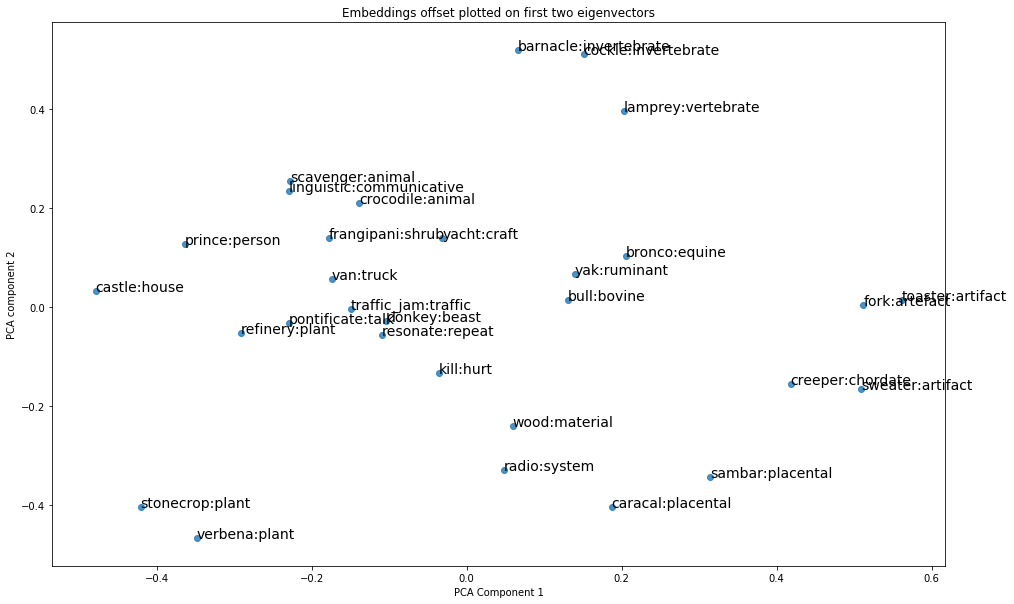

In [239]:
plt.figure(figsize=(16,10))
plt.scatter(dim_red[:,0], dim_red[:,1], alpha=0.8)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA component 2')
plt.title('Embeddings offset plotted on first two eigenvectors')
for i, sample in enumerate(rnd_wp_idx):
    #plt.annotate("%s:%s" % (train_datasets[0][sample][0], train_datasets[0][sample][1]), 
     #            xy=(dim_red[i, 0], dim_red[i, 1]), size=12)
    plt.annotate("%s:%s" % (related_words[sample][0], related_words[sample][1]), 
                 xy=(dim_red[i, 0], dim_red[i, 1]), size=14)

# Visualisation Time

In [8]:
# import results in dataframe
df = pd.read_csv('upload_ustalov_to_pandas.txt', header=0, sep="\t")

In [339]:
print (df.shape)
df.head()

(225, 8)


,id,embeddings,model,clusters,metric,mean_score,fold_std,lex_split
0,1,w2v,Cosine,1,MRR,0.037638,0.003266,0.02160
1,2,w2v,Cosine,1,MAP,0.019334,0.002230,0.01588
2,3,w2v,Cosine,1,p_at_1,0.017706,0.005194,0.01481
3,4,w2v,Cosine,1,p_at_5,0.019602,0.001960,0.01605
4,5,w2v,Cosine,1,p_at_10,0.018942,0.002205,0.01605


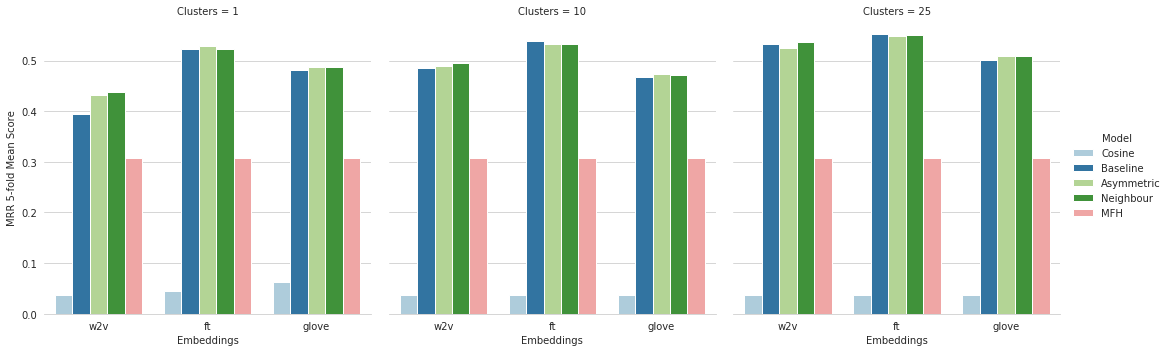

In [23]:
# plot MRR by embeddings, model, and baselines
df_mrr = df.loc[(df.metric=="MRR") & (df.embeddings != 'None'), ["clusters","embeddings","model", "mean_score"]]
df_mrr.columns = ['Clusters', 'Embeddings', 'Model', 'MRR 5-fold Mean Score']
sns.set_style("whitegrid")
pal = sns.color_palette("Paired")
g = sns.catplot(data=df_mrr, x='Embeddings', y='MRR 5-fold Mean Score', hue='Model', col='Clusters', kind='bar', palette=pal )
g.despine(left=True)
#g.set(xlabel='Embeddings', ylabel='MRR 5-fold Mean Score')


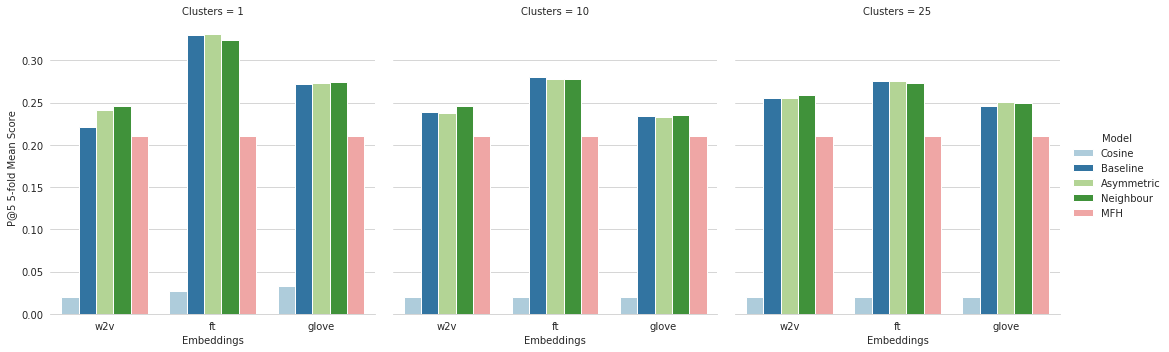

In [28]:
# p@5 results

df_p = df.loc[(df.metric=="p_at_5") & (df.embeddings != 'None'), ["clusters","embeddings","model", "mean_score"]]

df_p.columns = ['Clusters', 'Embeddings', 'Model', 'P@5 5-fold Mean Score']
sns.set_style("whitegrid")
pal = sns.color_palette("Paired")
g = sns.catplot(data=df_p, x='Embeddings', y='P@5 5-fold Mean Score', hue='Model', col='Clusters', kind='bar', palette=pal )
#g.set(xlabel='Embeddings', ylabel='P@5 5-fold Mean Score')
g.despine(left=True)


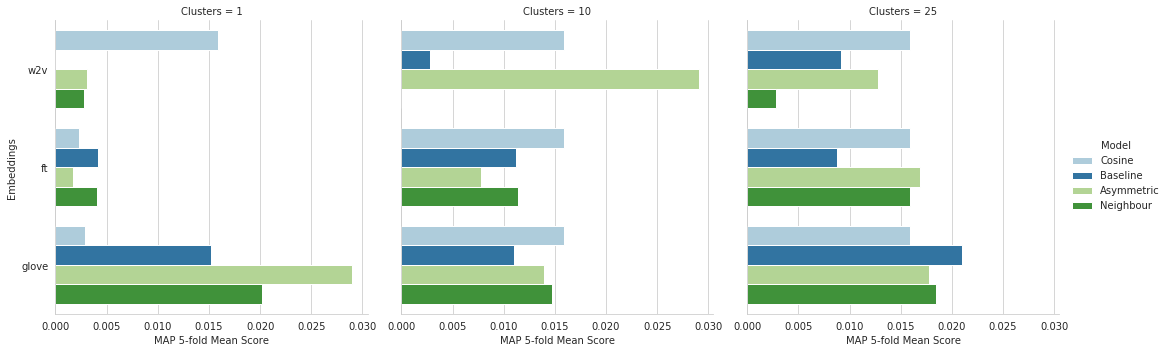

In [61]:
# lexical split results
df_lex = df.loc[(df.metric=="MAP") & (df.model != 'MFH'), ["clusters","embeddings","model", "lex_split"]]
df_lex.columns = ['Clusters', 'Embeddings', 'Model', 'MAP 5-fold Mean Score']
sns.set_style("whitegrid")
pal = sns.color_palette("Paired")
g = sns.catplot(data=df_lex, y='Embeddings', x='MAP 5-fold Mean Score', hue='Model', col='Clusters', kind='bar', orient='h', palette=pal )
g.set(xlabel='MAP 5-fold Mean Score')
#g.fig.subplots_adjust(top=0.9)
#g.fig.suptitle('MAP 5-fold Mean Score for Lexically-split Dataset over all Models, Embeddings')


In [78]:
# load train-test data excerpt
df_loss = pd.read_csv('upload_train_test_loss_pandas.txt', header=0, sep="\t")

#df_loss.head()
df_loss.columns=['Cluster', 'Epoch', 'Phase', 'Loss']
df_loss = df_loss.loc[df_loss.Cluster.isin([5,6,7,8]), :]

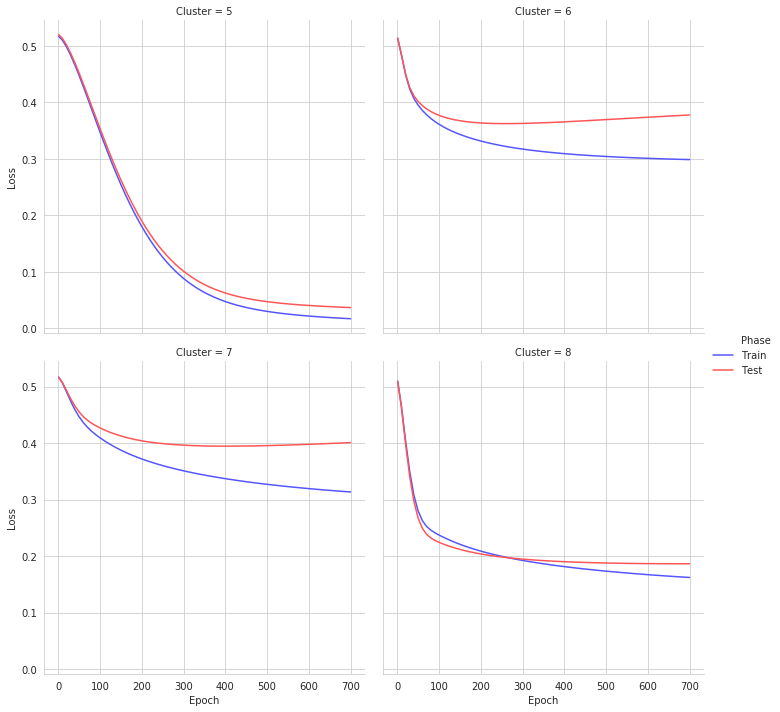

In [80]:
sns.set_style("whitegrid")
pal = sns.color_palette("seismic", n_colors=2)
g = sns.relplot(x="Epoch", y="Loss", hue="Phase", col="Cluster", col_wrap=2 ,kind="line", legend='full', data=df_loss, palette=pal)


In [110]:
# Fast Text single cluster baseline train-test loss
df_loss = pd.read_csv('upload_ft_train_test_loss_pandas.txt', header=0, sep="\t")

#df_loss.head()
df_loss.columns=['Cluster', 'Epoch', 'Phase', 'Loss']
#df_loss = df_loss.loc[df_loss.Cluster.isin([5,6,7,8]), :]

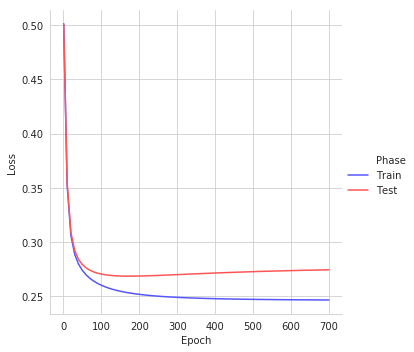

In [116]:
sns.set_style("whitegrid")
pal = sns.color_palette("seismic", n_colors=2)
g = sns.relplot(x="Epoch", y="Loss", hue="Phase",kind="line", legend='full', data=df_loss, palette=pal)

In [82]:
#prepare_args = {'w2v': model, 'seed':1000}
#prep = prepare.Prepare(prepare_args)
#prep(train_datasets[0], test_datasets[0])

# we already have train.npz in the directory based on the latest baseline run
cluster_args = {'train':'train.npz', 'seed':1000, 'k':10}
cl = cluster.Cluster(cluster_args)
cl('kmeans.pickle')

Just written the k-means result for k=10.


In [83]:
X_test = np.zeros((len(test_datasets[0]), 300))
Y_test = np.zeros((len(test_datasets[0]), 300))

for idx, sample in enumerate(test_datasets[0]):    
    X_test[idx] = model[sample[0]]
    Y_test[idx] = model[sample[1]]
    
    
X_train = np.zeros((len(train_datasets[0]), 300))
Y_train = np.zeros((len(train_datasets[0]), 300))

for idx, sample in enumerate(train_datasets[0]):    
    X_train[idx] = model[sample[0]]
    Y_train[idx] = model[sample[1]]

#test_clusters = cl.km.predict()

In [84]:
clusters = cl.km.predict(Y_train -  X_train)

In [104]:
# print tuples allocated to cluster
for c_id in range(4,8):    
    cluster_tuples = list(map(lambda x: train_datasets[0][x], np.where(clusters == c_id)[0]))
    # print first 20 examples
    print ("Cluster %d: " % (c_id+1))    
    for idx, (hypo, hyper) in enumerate(cluster_tuples):
        print (hypo, hyper)        
        if idx == 19:
            break
    print ("-"*30)

Cluster 5: 
camp place
sandy place
rendezvous place
courthouse place
volcano place
hill place
park place
dwell place
world place
moon place
bus place
school place
yard place
dig place
department place
asia place
supermarket place
ranch place
center place
pit place
------------------------------
Cluster 6: 
strawflower flower
violin instrument
violin device
handle part
handle touch
flatworm worm
papyrus sedge
person woman
chameleon saurian
chameleon lizard
encore concert
alder tree
see verify
see think
familiar spirit
macaque monkey
macaque primate
plum fruit
image picture
partial incomplete
------------------------------
Cluster 7: 
secret information
person individual
encore addition
encore performance
encore request
hem edge
hem sew
warm change
plum produce
plum food
rendezvous meeting
ear hear
intercourse activity
intercourse act
intercourse communication
intercourse interaction
intercourse sexuality
intentional voluntary
intentional deliberate
crash change
-------------------------

In [168]:
from collections import Counter
print (Counter(clusters))

# create average diff vector per cluster
# compute average hypernym per cluster
avg_diff_cluster = np.zeros((25, 300))
avg_hyper_cluster = np.zeros((25, 300))
for c in range(25):
    diff_cluster = (Y_train - X_train)[np.where(clusters == c)]
    hyper_cluster = Y_train[np.where(clusters == c)]
    avg_diff_cluster[c] = np.mean(diff_cluster, axis=0)
    avg_hyper_cluster[c] = np.mean(hyper_cluster, axis=0)
    


Counter({21: 959, 10: 861, 3: 512, 16: 345, 18: 308, 4: 288, 11: 284, 7: 246, 24: 243, 8: 217, 13: 203, 19: 161, 23: 150, 14: 144, 9: 142, 17: 132, 22: 123, 0: 120, 20: 105, 5: 78, 1: 71, 2: 70, 12: 57, 15: 32, 6: 22})


In [172]:
# confirm average hypernym per cluster and have a look at it
for c in range(25):
    print (c, model.most_similar([avg_hyper_cluster[c]], topn=1))

# print tuples allocated to cluster
list(map(lambda x: train_datasets[0][x], np.where(clusters ==0)[0]))

0 [('clothing', 0.842803955078125)]
1 [('object', 1.0000001192092896)]
2 [('animal', 0.9990752339363098)]
3 [('%_#F########_9v.jsn', 0.6921530961990356)]
4 [('chordate', 1.0)]
5 [('place', 1.0)]
6 [('human', 0.9877322316169739)]
7 [('invertebrate', 0.8255459070205688)]
8 [('animal', 0.9999702572822571)]
9 [('plant', 1.0000001192092896)]
10 [('By_Elise_Viebeck', 0.6847134828567505)]
11 [('vertebrate', 1.0)]
12 [('food', 0.9999999403953552)]
13 [('plant', 1.0000001192092896)]
14 [('placental', 1.0)]
15 [('angiosperm', 1.0)]
16 [('bird', 0.8558627367019653)]
17 [('artifact', 0.9358201026916504)]
18 [('build', 0.6968094706535339)]
19 [('mammal', 1.0)]
20 [('herb', 1.0)]
21 [('%_#F########_7v.jsn', 0.787582516670227)]
22 [('animal', 0.9999801516532898)]
23 [('person', 0.8491547107696533)]
24 [('tree', 0.811475932598114)]


[('jar', 'drinkware'),
 ('jar', 'kitchenware'),
 ('glove', 'clothing'),
 ('glove', 'clothes'),
 ('glove', 'accessory'),
 ('glove', 'commodity'),
 ('glove', 'garment'),
 ('glove', 'apparel'),
 ('hole', 'space'),
 ('rabbit', 'pet'),
 ('rabbit', 'meat'),
 ('hat', 'apparel'),
 ('hat', 'clothes'),
 ('hat', 'wear'),
 ('hat', 'garment'),
 ('hat', 'clothing'),
 ('hat', 'accessory'),
 ('hat', 'commodity'),
 ('corkscrew', 'kitchenware'),
 ('whale', 'seafood'),
 ('shirt', 'clothing'),
 ('shirt', 'clothes'),
 ('shirt', 'garment'),
 ('shirt', 'commodity'),
 ('shirt', 'apparel'),
 ('lobster', 'seafood'),
 ('robe', 'clothes'),
 ('robe', 'apparel'),
 ('robe', 'garment'),
 ('robe', 'commodity'),
 ('robe', 'clothing'),
 ('red', 'movie'),
 ('arm', 'supply'),
 ('piano', 'furniture'),
 ('desk', 'furniture'),
 ('desk', 'furnishing'),
 ('keep', 'store'),
 ('galaxy', 'collection'),
 ('blouse', 'apparel'),
 ('blouse', 'clothing'),
 ('blouse', 'commodity'),
 ('blouse', 'clothes'),
 ('blouse', 'garment'),
 ('pun

In [191]:
from sklearn.metrics.pairwise import cosine_similarity
# compute similarity between term + average offset and average hypernym of each cluster.  
# The word-pair is added to he cluster associated with the average hypernym vector which is closest 
# to the term + offset combination 

# the cosine similarity scalar values reside on the diagonal vector of the resulting matrix.
# we pick the top k (arbitrary) clusters and allocate the word pair to each.
# in this manner we avoid leaking the hypernym word in the prediction algorithm.

# the same principle can be used with Yamane.  After initial training, we end up with k clusters
# each containing the word-pairs that were allocated via the Yamane algorithm.  This structure
# can be used to devise the average hypernym-hyponym vector offset and average hypernym and work out the 
# most likely cluster/s to which unseen word-pairs can be allocated

# routine to predict best clusters for w
w = 0
print (np.argsort(
    np.diag(cosine_similarity((X_test[w] + avg_diff_cluster), avg_hyper_cluster))
)[::-1])

# find the actual similarities
np.diag(cosine_similarity((X_test[w] + avg_diff_cluster), avg_hyper_cluster))
#X_test[155] + avg_diff_cluster)
#avg_hyper_cluster.shape

[22 11  4  8 14 19 12  2  7  5  1 17  9 23 15 16  6 13 20 24  0 10 21  3
 18]


array([0.48281879, 0.69683616, 0.71752768, 0.37904017, 0.7762424 ,
       0.70361009, 0.6611306 , 0.7095158 , 0.7736649 , 0.68771724,
       0.45939174, 0.77662561, 0.72475781, 0.65513369, 0.76083339,
       0.66204772, 0.66147125, 0.69267339, 0.37701214, 0.75522491,
       0.59968578, 0.39115479, 0.78557172, 0.67300912, 0.51549742])

In [171]:
cl.km.predict((Y_test[236]-X_test[236]).reshape(1,-1))

array([10], dtype=int32)

# Scratch Pad

In [165]:
reload(cluster)

<module 'cluster' from '/home/jovyan/work/hyperstar/cluster.py'>

In [ ]:
# create embeddings arrays on which model will be trained
prepare_args = {'w2v': model, 'seed':1000}
prep = prepare.Prepare(prepare_args)
prep(train_datasets[1], test_datasets[1])

In [ ]:
# create clusters
cluster_args = {'train':'train.npz', 'seed':1000, 'k':10}
cl = cluster.Cluster(cluster_args)
cl('kmeans.pickle')

In [ ]:
# execute trainer
train_args = {'model':'baseline', 'train':'train.npz', 'test':'test.npz', 'stddev':0.01, 'lambdac':0.10,
              'seed':1000, 'num_epochs':700, 'batch_size':1024, 'gpu':False}

trainer = train.Trainer(train_args)
trainer()

# at this stage we have a trained model in the program root

In [20]:
# now we can evaluate the results
from multiprocessing import cpu_count
evaluate_args = {'model':'baseline','w2v':model, 'test': 'test.npz', 
                 'subsumptions':test_datasets[5], 'threads':cpu_count()}

evaluator = evaluate.Evaluator(evaluate_args)
predictions = evaluator(evaluate_args['model'])

268 268
Evaluating "baseline" on "test.npz".
The number of clusters is 25.
nn_vec...
nn_vec results covert...
done


In [25]:
predictions

{'chain': ['go',
  'build',
  'make',
  'develop',
  'write',
  'buy',
  'keep',
  'carry',
  'implement',
  'follow',
  'look',
  'relate',
  'extend',
  'send',
  'take'],
 'letter': ['thing',
  'statement',
  'remark',
  'phrase',
  'issue',
  'point',
  'notion',
  'fact',
  'state',
  'one',
  'country',
  'book',
  'word',
  'question',
  'concept'],
 'barrow': ['horse',
  'house',
  'wagon',
  'man',
  'truck',
  'farm',
  'word',
  'wooden',
  'boat',
  'cloth',
  'car',
  'town',
  'pig',
  'goat',
  'sheep'],
 'swine': ['ungulate',
  'ruminant',
  'carnivore',
  'herbivore',
  'ungulates',
  'mammal',
  'even-toed',
  'carnivores',
  'artiodactyl',
  'felid',
  'carnivoran',
  'bovid',
  'mustelid',
  'ruminants',
  'odd-toed'],
 'turnip': ['crucifer',
  'species',
  'vegetable',
  'cabbage',
  'tomato',
  'fungus',
  'nematode',
  'plant',
  'vegetables',
  'pathogen',
  'fungal',
  'fruit',
  'tuber',
  'bacterial',
  'thrip'],
 'export': ['use',
  'make',
  'export',
  'it

In [26]:
for w in predictions['van']:
    print (w, model.similarity(w, 'van'))

vessel 0.3641204
conveyance 0.32071328
vehicle 0.54102725
transportation 0.43584195
car 0.55908006
transport 0.44454044
equipment 0.34976685
business 0.338223
truck 0.6218967
building 0.3593793
metal 0.38592818
water 0.3428453
vehicles 0.48591653
automobile 0.42168635
cargo 0.44439024


In [ ]:
test_datasets[5]

In [ ]:
scorer = semeval_eval.HypernymEvaluation(test_datasets[5])

print ("SemEval evaluation:")
score_names, all_scores = scorer.get_evaluation_scores(predictions)
for k in range(len(score_names)):
    print (score_names[k]+': '+str(round(sum([score_list[k] for score_list in all_scores]) / len(all_scores), 5)))    

In [ ]:
from sklearn.preprocessing import normalize
emb_offsets = normalize(emb_offsets)
np.linalg.norm(emb_offsets, axis=1)

In [147]:
# let's try to reduce components to 50
emb_offsets = Y_matrix - X_matrix


Cumulative explained variation for 50 principal components: 0.8419791238561386


In [201]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(emb_offsets)

[t-SNE] Computing 29 nearest neighbors...
[t-SNE] Indexed 30 samples in 0.000s...
[t-SNE] Computed neighbors for 30 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 30 / 30
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 42.870159
[t-SNE] KL divergence after 300 iterations: 0.612464


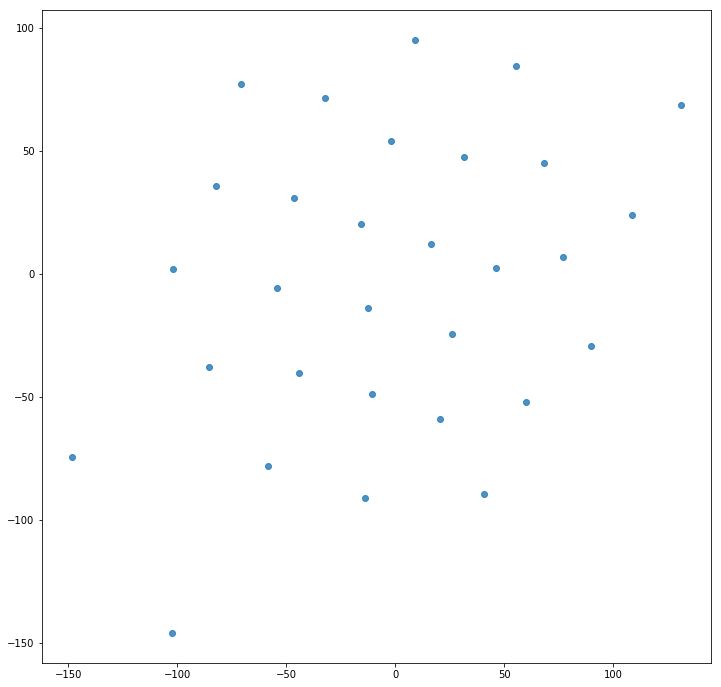

In [200]:
plt.figure(figsize=(12,12))
plt.scatter(tsne_results[:,0], tsne_results[:,1], alpha=0.8)

In [ ]:
#for c in range(25):
#    print (model.most_similar([X_test[236] + avg_diff_cluster[c]], topn=2))


In [221]:
#### from scipy.stats import spearmanr

spearmanr([0.031976,0.283602,0.248178,0.26234,0.284514,0.248274,0.268072,0.28524,0.249816,0.266568],
          [0.03149,0.257312,0.22133,0.234804,0.258888,0.220766,0.24011,0.259914,0.223242,0.23835])

SpearmanrResult(correlation=0.9878787878787878, pvalue=9.307459988955517e-08)

In [ ]:
# plot MRR by embeddings, model, and baselines

sub_df_1 =\
df.loc[(df.clusters==1) & (df.metric=="MRR") & (df.embeddings != 'None'), ["embeddings","model", "mean_score", "fold_std"]]

sub_df_10 =\
df.loc[(df.clusters==10) & (df.metric=="MRR") & (df.embeddings != 'None'), ["embeddings","model", "mean_score", "fold_std"]]

sub_df_25 =\
df.loc[(df.clusters==25) & (df.metric=="MRR") & (df.embeddings != 'None'), ["embeddings","model", "mean_score", "fold_std"]]

#res_2 =\
#df.loc[(df.metric=="MRR") & (df.embeddings == 'None'), ["embeddings","model", "mean_score", "fold_std"]]

#sub_df = pd.concat([res_1, res_2])

p_cross_1 = pd.crosstab(sub_df_1.embeddings, sub_df_1.model, values=sub_df_1.mean_score, aggfunc='mean')
p_cross_1 = p_cross_1.reindex(columns=["Baseline", "Asymmetric","Neighbour","Cosine","MFH"])

p_cross_2 = pd.crosstab(sub_df_10.embeddings, sub_df_10.model, values=sub_df_10.mean_score, aggfunc='mean')
p_cross_2 = p_cross_2.reindex(columns=["Baseline", "Asymmetric","Neighbour","Cosine","MFH"])

p_cross_3 = pd.crosstab(sub_df_25.embeddings, sub_df_25.model, values=sub_df_25.mean_score, aggfunc='mean')
p_cross_3 = p_cross_2.reindex(columns=["Baseline", "Asymmetric","Neighbour","Cosine","MFH"])

fig, axes = plt.subplots(nrows =1, ncols=3)
ax1 = p_cross_1.plot(kind='bar', figsize=(15,6), colormap='Paired', rot=0, ax=axes[0], title='Clusters = 1')
ax1.set_ylim([0, 0.70])
ax1.set_ylabel("MRR")
ax1.yaxis.grid(linestyle='-', linewidth=0.25)

ax2 = p_cross_2.plot(kind='bar', figsize=(15,6), colormap='Paired', rot=0, ax=axes[1], title='Clusters = 10')
ax2.set_ylim([0, 0.70])
ax2.set_ylabel("MRR")
ax2.yaxis.grid(linestyle='--', linewidth=0.25)

ax3 = p_cross_3.plot(kind='bar', figsize=(15,6), colormap='Paired', rot=0, ax=axes[2], title='Clusters = 25')
ax3.set_ylim([0, 0.70])
ax3.set_ylabel("MRR")
ax3.yaxis.grid(linestyle='--', linewidth=0.25)


In [20]:
# rename columnd test
#df.loc[:5, ["embeddings", "clusters", "mean_score"]]
df_test = df.loc[(df.metric=="p_at_5") & (df.embeddings != 'None'), ["clusters","embeddings","model", "mean_score"]]
df_test.columns = ['Clusters', 'Embeddings', 'Model', 'MRR 5-fold Mean Score']
df_test

,Clusters,Embeddings,Model,MRR 5-fold Mean Score
3,1,w2v,Cosine,0.019602
8,1,w2v,Baseline,0.220768
13,10,w2v,Baseline,0.239214
18,25,w2v,Baseline,0.255918
23,1,w2v,Asymmetric,0.241402
28,10,w2v,Asymmetric,0.237532
33,25,w2v,Asymmetric,0.255252
38,1,w2v,Neighbour,0.245724
43,10,w2v,Neighbour,0.245882
48,25,w2v,Neighbour,0.259528
